In [2]:
#pip install mlxtend
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import warnings
import os
import platform
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from IPython.display import display
color = sns.color_palette()
import pyfpgrowth
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.max_colwidth', -1)

In [3]:
def display_graph(obj, x_label, y_label, title, graph_color, grid_style, rotation):
    if grid_style != '':
        sns.set_style(grid_style)
    f, ax = plt.subplots(figsize=(15, 15))
    if rotation != '':
        plt.xticks(rotation=rotation, fontsize=10)
    else:
        plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sns.barplot(obj.index, obj.values)
    plt.ylabel(y_label, fontsize=16)
    plt.xlabel(x_label, fontsize=16)
    plt.title(title, fontsize=24, color='blue')
    plt.show()

In [15]:
class InstaCart:

    def __init__(self):
        self.order_products_train = pd.read_csv('../input/order_products__train.csv')
        self.order_products_prior = pd.read_csv('../input/order_products__prior.csv')
        self.orders = pd.read_csv('../input/orders.csv')
        self.products = pd.read_csv('../input/products.csv')
        self.aisles = pd.read_csv('../input/aisles.csv')
        self.departments = pd.read_csv('../input/departments.csv')
       
    def generate_unique_dataset(self):
        unique_orders_products = pd.concat([self.order_products_train, self.order_products_prior], axis=0)
        return unique_orders_products

    def most_ordered_product(self, order_items):
        most_ordered = grouped = order_items.groupby(["product_id", "reordered"]).size().reset_index(
            name='Total_reorders')
        most_ordered = pd.merge(most_ordered, self.products[['product_id', 'product_name']], how='left',
                                on=['product_id']).sort_values(by='Total_reorders', ascending=False)[:10]
        most_ordered = most_ordered.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)
        display_graph(most_ordered, 'Most ordered Products', 'Number of Reorders', 'Most Ordered Products', 'blue',
                      'darkgrid', 'vertical')

    def get_rush_hours(self):
        rush_hours = self.orders.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
        rush_hours = rush_hours.order_hour_of_day.value_counts()
        display_graph(rush_hours, 'Number of orders', 'Hours of order in a day', 'Orders based on hour of day',
                      'blue',
                      'darkgrid', '')

    def get_rush_days(self):
        rush_days = self.orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
        rush_days = rush_days.order_dow.value_counts()
        print(rush_days)
        display_graph(rush_days, 'Days of order in a week', 'Number of orders', 'Orders based on Day of Week',
                      'blue', '', '')

    # most imp department with respect to products
    def get_most_imp_dept(self):
        items = pd.merge(left=pd.merge(left=self.products, right=self.departments, how='left'), right=self.aisles,
                         how='left')
        products_in_department = items.groupby("department")["product_id"].size().reset_index(name='Total_products')
        products_in_department['ratio'] = products_in_department["Total_products"].apply(
            lambda x: x / products_in_department['Total_products'].sum())
        products_in_department.sort_values(by='Total_products', ascending=False, inplace=True)
        products_in_department = products_in_department.groupby(['department']).sum()['Total_products'].sort_values(
            ascending=False)
        display_graph(products_in_department, 'Departments', 'Number of products',
                      'Most Important Departments (By number of products)', 'blue', '', 'vertical')

    # most sales by department
    def get_most_sales_by_dept(self):
        user_flow = self.orders[['user_id', 'order_id']].merge(self.order_products_train[['order_id', 'product_id']],
                                                               how='inner', left_on='order_id', right_on='order_id')
        items = pd.merge(left=pd.merge(left=self.products, right=self.departments, how='left'), right=self.aisles,
                         how='left')
        user_flow = user_flow.merge(items, how='inner', left_on='product_id',
                                    right_on='product_id')
        department_order_groups = user_flow.groupby("department")["order_id"].size().reset_index(name='Total_orders')
        department_order_groups['Ratio'] = department_order_groups["Total_orders"].apply(
            lambda x: x / department_order_groups['Total_orders'].sum())
        department_order_groups.sort_values(by='Total_orders', ascending=False, inplace=True)
        department_order_groups = department_order_groups.groupby(['department']).sum()['Total_orders'].sort_values(
            ascending=False)
        display_graph(department_order_groups, 'Departments', 'Number of Orders',
                      'Best selling department by orders count', 'blue', '', 'vertical')
        self.get_most_sold_aisles_over_dept(user_flow)

    def get_most_sold_aisles_over_dept(self, user_flow):
        grouped = user_flow.groupby("aisle")["order_id"].size().reset_index(name='Total_orders')
        grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x / grouped['Total_orders'].sum())
        grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
        # grouped.head(10)
        grouped = grouped.groupby(['aisle']).sum()['Total_orders'].sort_values(ascending=False)[:15]
        display_graph(grouped, 'Aisles', 'Number of Orders', 'Best selling aisles over departments', 'blue', '',
                      'vertical')

    def gen_associate_rules(self):
        # grouped = self.order_products_prior.groupby('order_id')['product_id'].apply(list)
        # print(grouped)
        # print(self.products[['product_id', 'product_name']])
        order_items = self.generate_unique_dataset()
        order_items = order_items[0:100000].join(self.products, on='product_id', lsuffix='_left', rsuffix='_right')
        # [['order_id','product_name']])
        order_items = order_items.dropna()
        grouped = order_items.groupby('order_id')['product_name'].apply(list)
#         patterns = pyfpgrowth.find_frequent_patterns(grouped, 2)
#         display(patterns)
#         rules = pyfpgrowth.generate_association_rules(patterns, 0.7)
#         display(rules)
        #         display(grouped.head())
        te = TransactionEncoder()
        te_ary = te.fit(grouped).transform(grouped)
        df = pd.DataFrame(te_ary)
        df = pd.DataFrame(te_ary, columns=te.columns_)
#         display(df.columns)
        patterns = fpgrowth(df, min_support=0.01, use_colnames=True)
        patterns = patterns.sort_values(by='support')
        display(patterns)
        
    # number of products in most of the order
    def number_of_products_most_order(self, data_order_products_all):
        grouped = data_order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
        grouped = grouped.add_to_cart_order.value_counts()
        display_graph(grouped,'Number of products added in order', 'Number of orders', 'Distribution of number of products in the order', 'blue', 'darkgrid', 'vertical')
   
    # products either reordered or not    
    def unique_products_either_reordered_or_not(self, data_order_products_all):
        grouped = data_order_products_all.groupby("reordered")["product_id"].aggregate("count").reset_index(name='Total_products')
        grouped = grouped.groupby("reordered")["Total_products"].aggregate("max").sort_values(ascending=False)
        display_graph(grouped,'Reordered or Not Reordered', 'Number of Products', 'Number of unique products either reordered or not', 'blue', 'darkgrid', 'vertical')    

    # product and reorder probability
    def most_reorder_probability_product(self, data_order_products_all):
        grouped = data_order_products_all.groupby("product_id")["reordered"].aggregate("sum").reset_index(name='reorder_sum')
        grouped1 = data_order_products_all.groupby("product_id")["reordered"].aggregate("count").reset_index(name='reorder_total')
        grouped = pd.merge(grouped, grouped1[['product_id', 'reorder_total']], how='inner', on=['product_id'])
        grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total'] #Calculating the probability at product level
        grouped = pd.merge(grouped, self.products[['product_id', 'product_name']], how='left', on=['product_id'])
        grouped = grouped[grouped.reorder_total > 75].sort_values(by='reorder_probability', ascending=False)[:10]
        grouped = grouped.groupby("product_name")["reorder_probability"].aggregate('max').sort_values(ascending=False)
        display_graph(grouped,'Products', 'Reorder probability', 'Most reorder probability by Products', 'blue', 'darkgrid', 'vertical')
    
    # department and reorder probability
    def most_reorder_probability_department(self, data_order_products_all):
        grouped = data_order_products_all.groupby("product_id")["reordered"].aggregate("sum").reset_index(name='reorder_sum')
        grouped1 = data_order_products_all.groupby("product_id")["reordered"].aggregate("count").reset_index(name='reorder_total')
        grouped = pd.merge(grouped, grouped1[['product_id', 'reorder_total']], how='inner', on=['product_id'])
        grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total'] #reorder probability at product level
        grouped = pd.merge(grouped, self.products[['product_id', 'department_id']], how='left', on=['product_id'])
        grouped = pd.merge(grouped, self.departments[['department_id', 'department']], how='left', on=['department_id'])
        grouped1 = grouped.groupby("department", as_index=False)["reorder_sum"].aggregate({'reorder_sum_department': 'sum'})
        grouped2 = grouped.groupby("department", as_index=False)["reorder_total"].aggregate({'reorder_total_department': 'sum'})
        grouped = pd.merge(grouped1, grouped2[['department', 'reorder_total_department']], how='left', on=['department'])
        grouped['reorder_probability_department'] = grouped['reorder_sum_department'] / grouped['reorder_total_department'] #reorder probability at department level
        grouped = grouped.groupby("department")["reorder_probability_department"].aggregate('max').sort_values(ascending=False)
        display_graph(grouped,'Departments', 'Reorder probability', 'Most reorder probability by Departments', 'blue', 'darkgrid', 'vertical')
    
    # number of orders & reorders by customers
    def number_of_reorders_by_customers(self):
        grouped = self.orders.groupby("user_id")["order_number"].aggregate('max').sort_values(ascending=False).reset_index()
        grouped = grouped.order_number.value_counts().sort_values(ascending=False)
        display_graph(grouped,'Number of reorders', 'Number of customers', 'Number of reorders by customer', 'blue', 'darkgrid', 'vertical')
    
    # frequency of reorders by number of orders
    def frequency_of_reorders_by_orders(self):
        grouped = self.orders.groupby("days_since_prior_order")["order_id"].aggregate('count').sort_values(ascending=False)
        display_graph(grouped,'Period of reorders', 'Number of orders', 'Frequency of reorders by orders', 'blue', 'darkgrid', 'vertical')     
    
    # most reordered product 
    def most_reordered_product(self,data_order_products_all):
        grouped = data_order_products_all.groupby("product_id")["reordered"].size().reset_index(name='Total_reorders')
        grouped = pd.merge(grouped, self.products[['product_id', 'product_name']], how='left', on=['product_id'])
        grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:20]
        grouped  = grouped.groupby("product_name")['Total_reorders'].aggregate("max").sort_values(ascending=False)
        display_graph(grouped,'Products', 'Reorders', 'Most Re-ordered products', 'blue', 'darkgrid', 'vertical')
    
    # most reordered department
    def most_reorders_placed_in_dept(self,data_order_products_all):
        grouped = data_order_products_all.groupby("product_id")["reordered"].size().reset_index(name='Total_reorders')
        grouped = pd.merge(grouped, self.products[['product_id', 'department_id']], how='left', on=['product_id'])
        grouped = pd.merge(grouped, self.departments[['department_id', 'department']], how='left', on=['department_id'])
        grouped = grouped.groupby("department")["Total_reorders"].aggregate("max").sort_values(ascending=False)[:10]
        display_graph(grouped,'departments', 'Reorders', 'Most Re-orders placed in departments', 'blue', 'darkgrid', 'vertical')
    
    # Aisle with most orders   
    def aisle_orders(self):
        items  = pd.merge(left =pd.merge(left=self.products, right=self.departments, how='left'), right=self.aisles, how='left')
        display(items.head())
        grouped = items.groupby(["department", "aisle"])["product_id"].size().reset_index(name='Total_products')
        grouped.sort_values(by='Total_products', ascending=False, inplace=True)
        fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))
        for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
            g = sns.barplot(group.aisle, group.Total_products , ax=ax)
            ax.set(xlabel = "Products", ylabel=" Number of products")
            g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
            ax.set_title(aisle, fontsize=15)
        
if __name__ == '__main__':
    iCart = InstaCart()
    unique_order_products = iCart.generate_unique_dataset()
    iCart.most_ordered_product(unique_order_products)
    iCart.get_rush_hours()
    iCart.get_rush_days()
    iCart.get_most_imp_dept()
    iCart.get_most_sales_by_dept()
    iCart.gen_associate_rules()
    iCart.most_reordered_product(unique_order_products)
    iCart.most_reorders_placed_in_dept(unique_order_products)
    iCart.aisle_orders()
    iCart.number_of_products_most_order(unique_order_products)
    iCart.unique_products_either_reordered_or_not(unique_order_products)
    iCart.most_reorder_probability_product(unique_order_products)
    iCart.most_reorder_probability_department(unique_order_products)
    iCart.number_of_reorders_by_customers()
    iCart.frequency_of_reorders_by_orders()

IndentationError: expected an indented block (<ipython-input-15-8e4e6b7d5242>, line 11)

In [8]:
    uniqe_order_products = iCart.generate_unique_dataset()
    display(unique_order_products)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


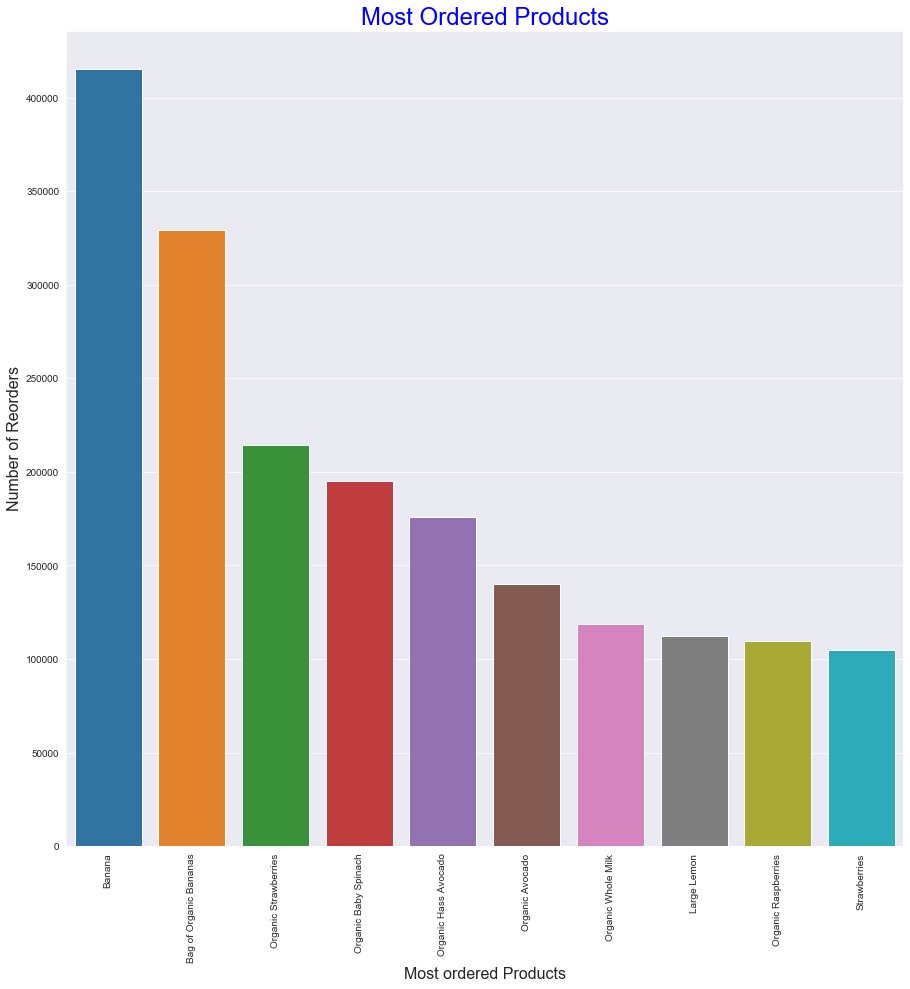

In [9]:
    iCart.most_ordered_product(unique_order_products)

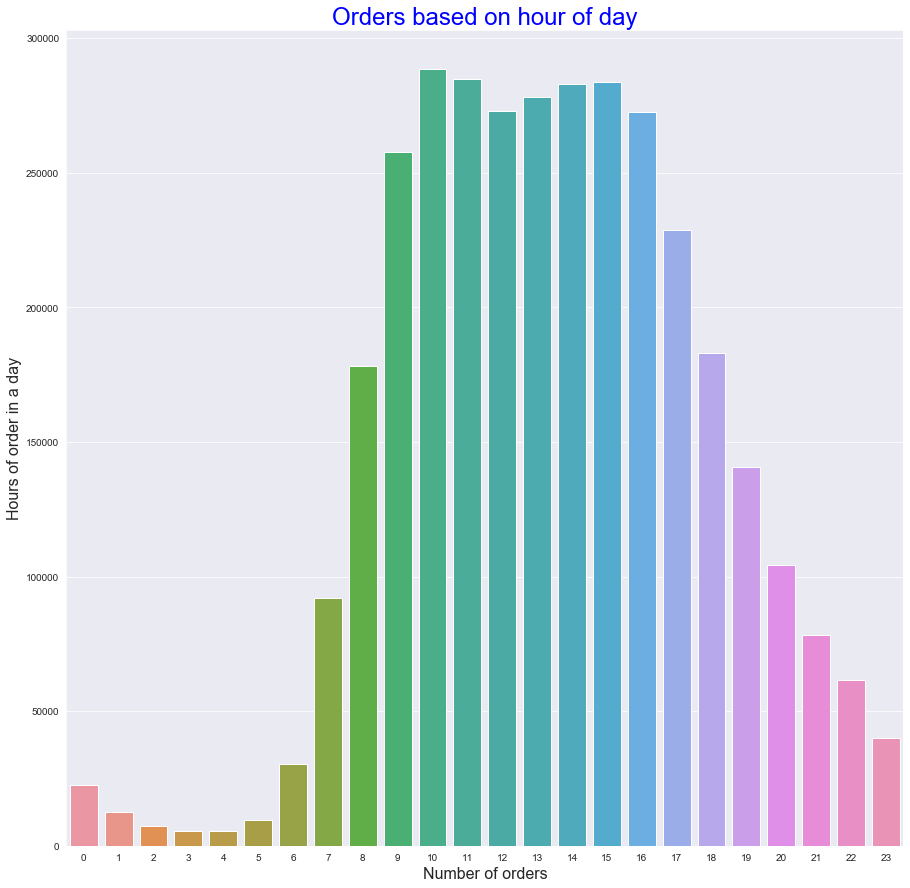

In [10]:
iCart.get_rush_hours()

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64


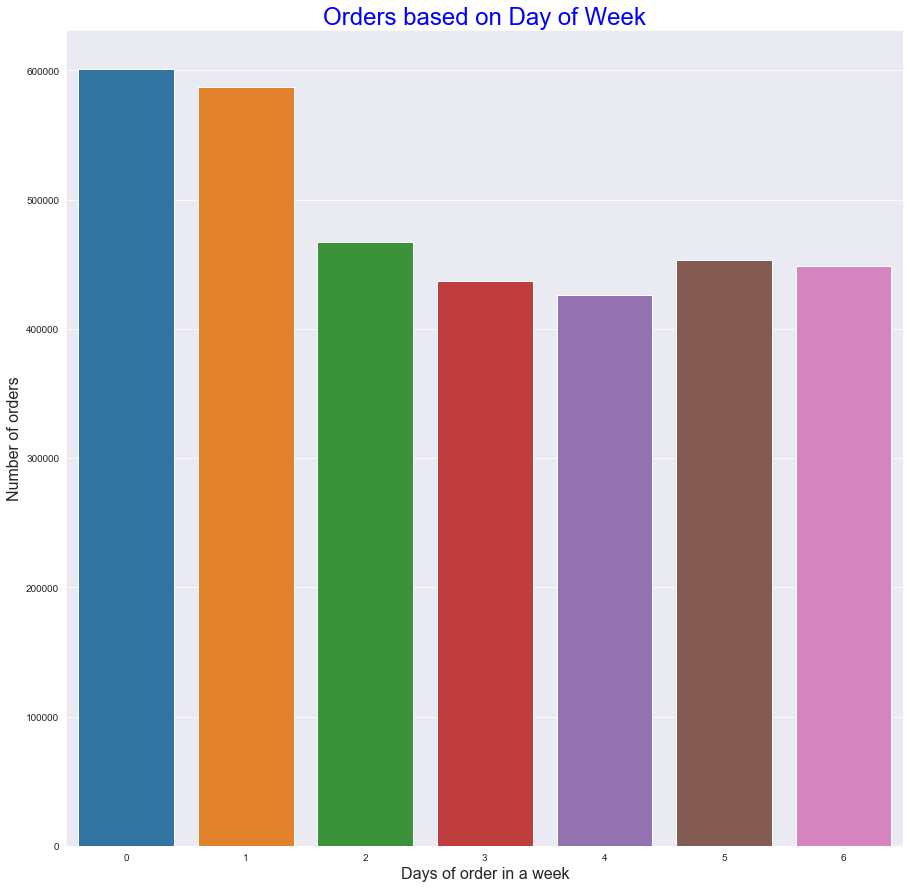

In [11]:
iCart.get_rush_days()

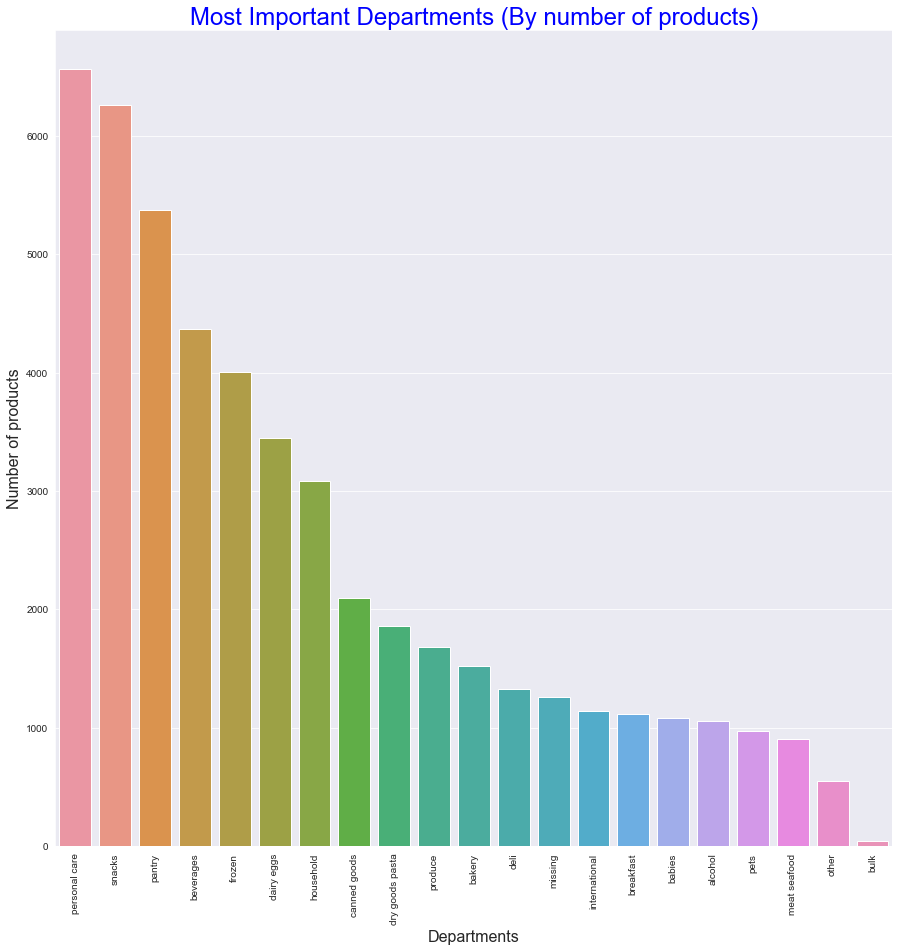

In [12]:
iCart.get_most_imp_dept()

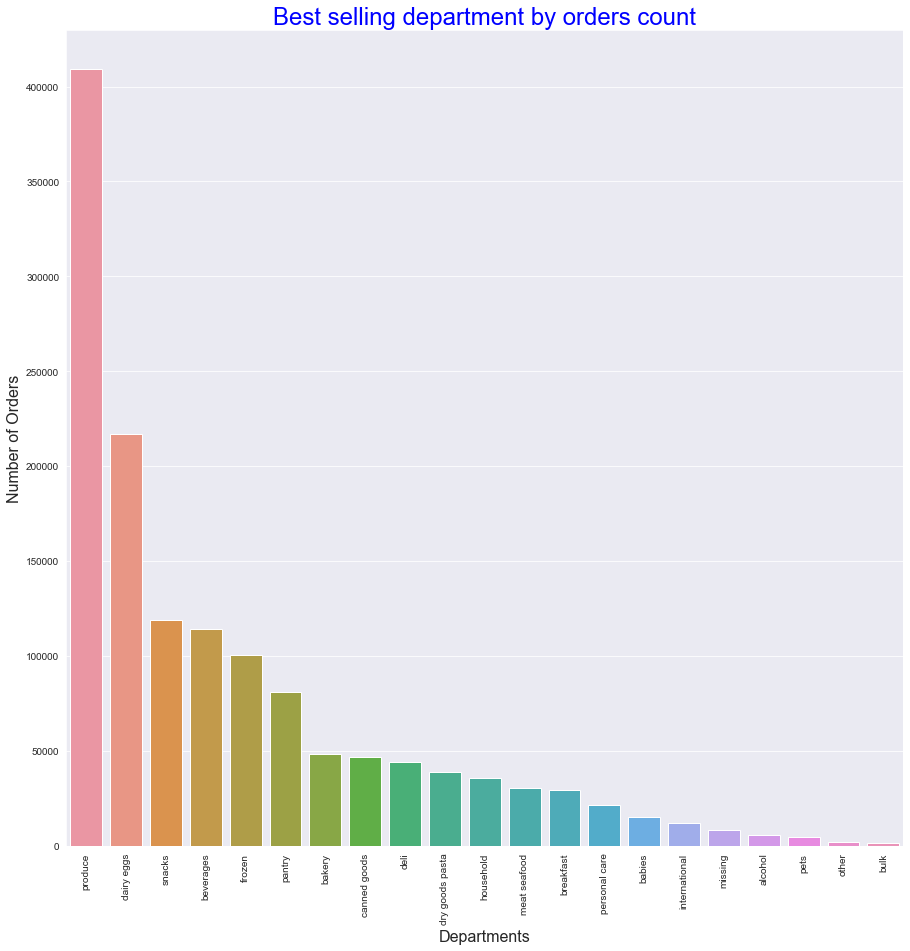

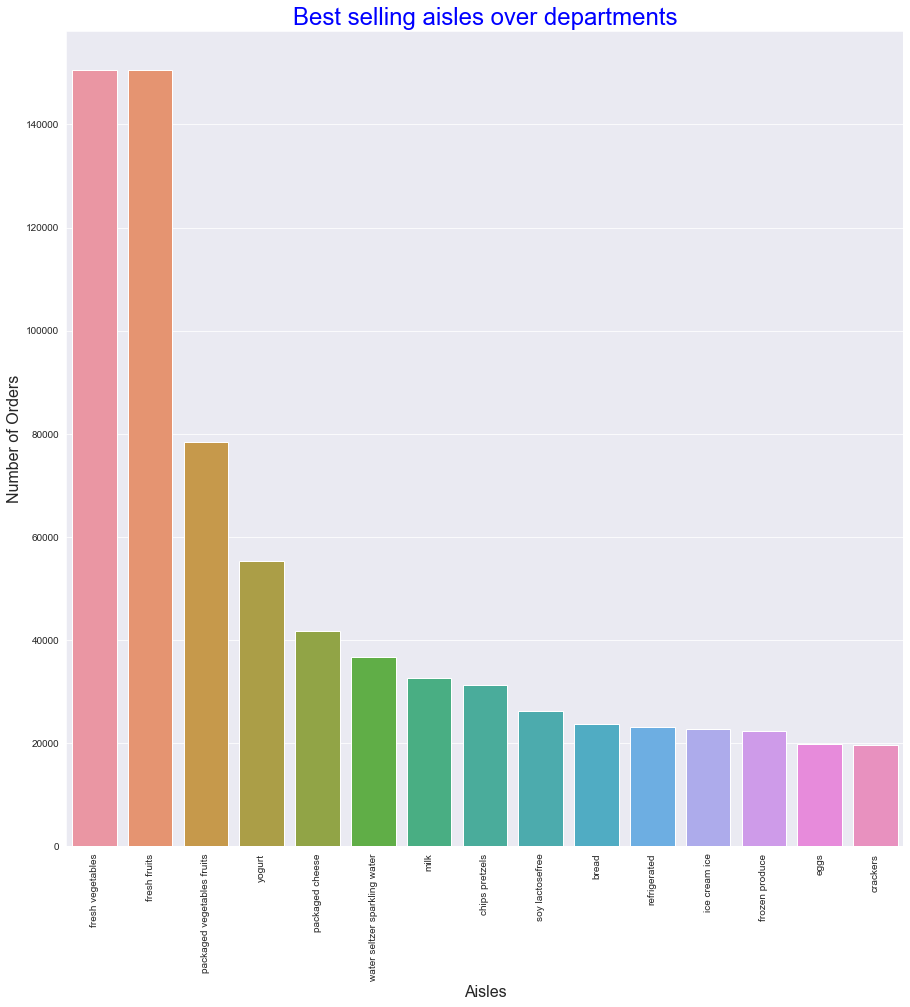

In [13]:
iCart.get_most_sales_by_dept()

In [1]:
iCart.gen_associate_rules()

NameError: name 'iCart' is not defined